1.1. Wybierz ze zbioru Plantdoc podzbiór kilkudziesięciu zdjęć przedstawiających 
trzy choroby roślin jednego gatunku (np. 3 choroby ziemniaków lub 3 choroby 
pomidorów).

In [ ]:
import os
import random
import socket
import urllib.request


def download_random_images_from_github(github_folder_url, local_folder_name="photos", num_images=30, seed=42):
    # set seed for reproducibility
    random.seed(seed)

    # Set timeout for requests
    socket.setdefaulttimeout(30)

    # Create local folder if it does not exist
    if not os.path.exists(local_folder_name):
        os.mkdir(local_folder_name)

    # Get list of file names in GitHub folder
    response = urllib.request.urlopen(github_folder_url)
    html = response.read()
    file_names = [f.split('href="')[-1].split('"')[0]
                  for f in html.decode().split('\n') if ".jpg" in f]

    # Select random file names
    random_files = random.sample(file_names, num_images)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
    }

    # Download each file
    for file_name in random_files:
        url = f"https://raw.githubusercontent.com{file_name.replace('/blob', '')}"
        file_path = os.path.join(local_folder_name, file_name.split("/")[-1])
        if os.path.exists(file_path):
            print(f"File {file_path} already exists. Skipping.")
            continue
        else:
            print(f"Downloading {url}")

        request = urllib.request.Request(url, headers=headers)
        response = urllib.request.urlopen(request)
        data = response.read()
        with open(file_path, 'wb') as f:
            f.write(data)


url1 = "https://github.com/pratikkayal/PlantDoc-Dataset/tree/master/train/Tomato%20leaf%20late%20blight"
url2 = "https://github.com/pratikkayal/PlantDoc-Dataset/tree/master/train/Tomato%20leaf%20bacterial%20spot"
url3 = "https://github.com/pratikkayal/PlantDoc-Dataset/tree/master/train/Tomato%20leaf%20mosaic%20virus"

download_random_images_from_github(url1, "photos", 30)
download_random_images_from_github(url2, "photos", 30)
download_random_images_from_github(url3, "photos", 30)


1.2. Wczytaj zdjęcia do pamięci. Po wczytaniu każde zdjęcie będzie trójwymiarowym 
tensorem. Pomocna będzie biblioteka imageio lub Pillow.

1.3. Przeskaluj wszystkie zdjęcia do rozdzielczości 224×224, tak aby wszystkie 
obrazy miały ten sam rozmiar, równy 224×224×3.

1.4. Skonwertuj obrazy do skali szarości, tak aby z trójwymiarowego 
tensorareprezentującego dane zdjęcie otrzymać tablicę dwuwymiarową

In [3]:
import os
import numpy as np
from PIL import Image

# import all photos from given directory
dir_path = "./photos/"
photos = []
for file in os.listdir(dir_path):
    if file.endswith(".jpg"):
        im = Image.open("./photos/"+file)

        # rescale im image to 224 x 224
        im = im.resize((224, 224))

        # convert to grayscale
        im = im.convert('L')

        photos.append(np.array(im))
photos = np.array(photos)


1.5. Skonwertuj obrazy, będące teraz tablicami dwuwymiarowymi (macierzami) na 
wektory.

In [4]:
import numpy as np

# convert photos to vectorized form
images_vectorized = []
for image in photos:
    image_vectorized = image.reshape(-1)
    images_vectorized.append(image_vectorized)
images_vectorized = np.array(images_vectorized)


1.6. Przeprowadź standaryzację obrazów, czyli od każdego obrazu odemij średni 
obraz, a następnie podziel przez odchylenie standardowe.

In [5]:
# standardize images
X = (images_vectorized - np.mean(images_vectorized, axis=0)) / np.std(images_vectorized, axis=0)

2.1.  Wykonaj transformację PCA.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
X_pca = pca.fit_transform(X)

2.2. Jak wyglądała dla tego zbioru macierz kowariancji przed transformacjąPCA, a 
jak po jej wykonaniu?

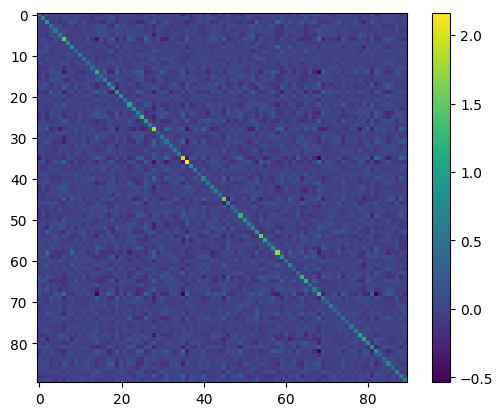

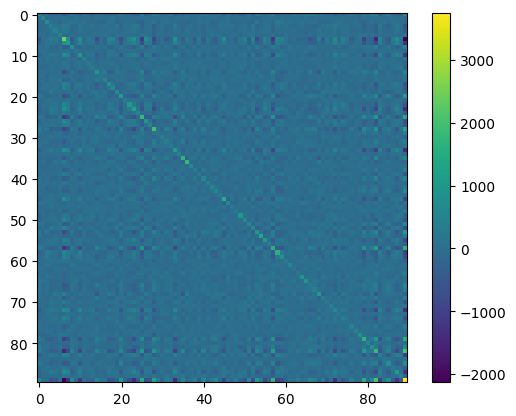

In [7]:
# create covariance matrix of X (use float32)
cov = np.cov(X, dtype=np.float32)

# show covariance matrix as plot with detailed colorbar and its meaning
import matplotlib.pyplot as plt

plt.imshow(cov)
plt.colorbar()
plt.show()

# do the same for X_pca
cov = np.cov(X_pca, dtype=np.float32)

plt.imshow(cov)
plt.colorbar()
plt.show()



2.3. Jak wyglądało średnie zdjęcie, które odjęliśmy od pozostałych, by wycentrować 
zbiór?

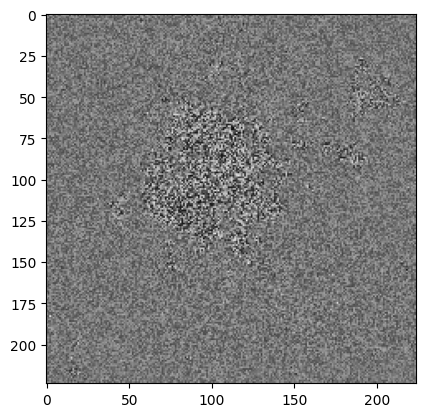

In [9]:
mean_image = np.mean(X, axis=0)
import matplotlib.pyplot as plt
plt.imshow(mean_image.reshape((224, 224)), cmap='gray')

plt.show()

2.4. Jak wyglądają znalezione nowe wektory bazowe (czyli główne składowe,ang. 
principal components)? Zaprezentuj je posortowane według powiązanej 
wariancji.


In [11]:
# wektory bazowe
components = pca.components_

# posortowanie wektorów bazowych według powiązanej wariancji
sorted_indices = np.argsort(pca.explained_variance_)[::-1]
sorted_components = components[sorted_indices]


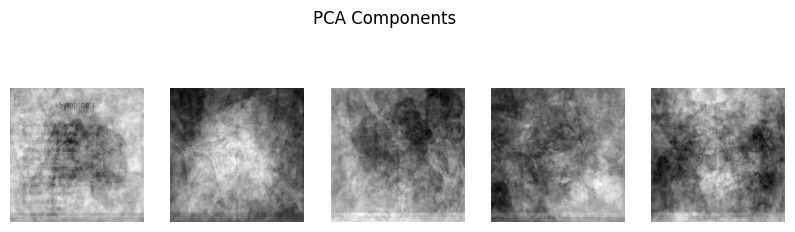

In [12]:
import matplotlib.pyplot as plt

# funkcja pomocnicza do wyświetlenia obrazów
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 3))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

# wyświetlenie wektorów bazowych jako obrazów
plot_images(sorted_components[:5].reshape(-1, 224, 224), 'PCA Components')


2.5. Skonwertuj obrazy, będące teraz tablicami dwuwymiarowymi (macierzami) na 
wektory.

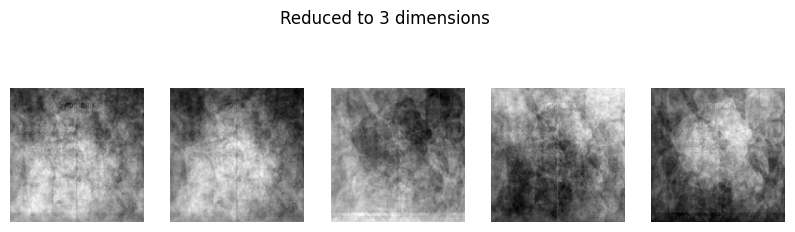

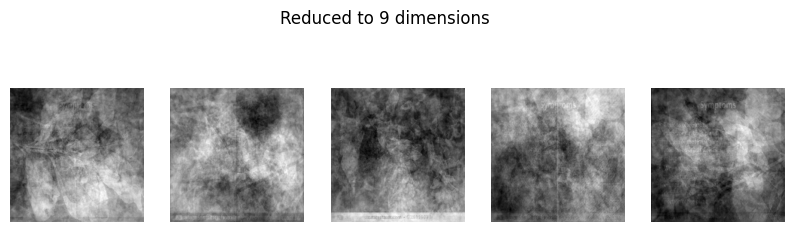

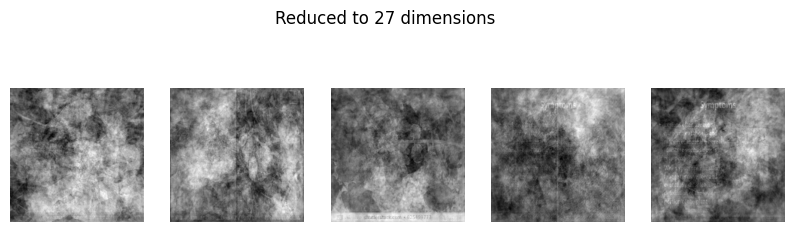

In [13]:
# liczba wymiarów do redukcji
dimensions = [3, 9, 27]

# lista przechowująca zredukowane obrazy
reduced_images = []

for d in dimensions:
    # stworzenie instancji klasy PCA
    pca = PCA(n_components=d)

    # przeprowadzenie PCA na danych
    X_pca = pca.fit_transform(X)

    # odwrotna transformacja PCA
    X_reduced = pca.inverse_transform(X_pca)

    # dodanie zredukowanych obrazów do listy
    reduced_images.append(X_reduced)

# wyświetlenie zredukowanych obrazów
for i, d in enumerate(dimensions):
    plot_images(reduced_images[i][:5].reshape(-1, 224, 224), f'Reduced to {d} dimensions')


2.6. Przedstaw wykres wariancji wyjaśnionej.

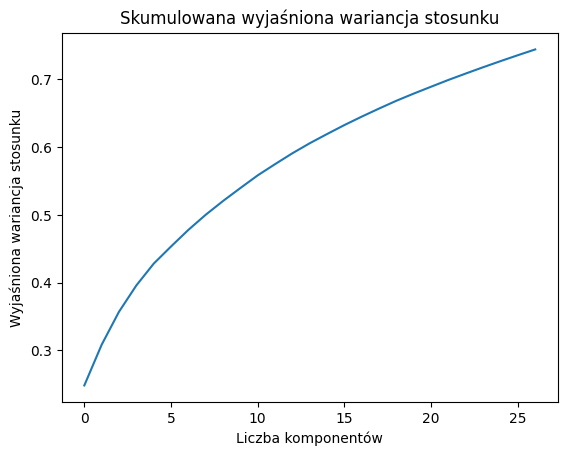

In [14]:
# wykres wariancji wyjaśnionej
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Liczba komponentów')
plt.ylabel('Wyjaśniona wariancja stosunku')
plt.title('Skumulowana wyjaśniona wariancja stosunku')
plt.show()
